In [76]:
# first to run everytime
# %config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import os

### Contour plot function

In [212]:
def CDF_contour(linename, objname, fitting_table,
                plot=True, cont=False, pix_ref=None, coord_ref=None, output=None, print_obj=False,
                sigma_floor=0, nofits=False, offset=True, limits=None, cmap='Blues_r', oversample=4,
                no_coords_output=False, offset_sizes=None):

    from scipy.interpolate import griddata, LinearNDInterpolator
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from astropy.io import ascii, fits
    import numpy as np
    import matplotlib.pyplot as plt

    # get the line data
    fitting = ascii.read(fitting_table)
    data = fitting[(fitting['Object'] == objname) & (fitting['Line'] == linename) & \
                   (fitting['Pixel_No.'] != 'c') & (fitting['Validity'] == 1)]
    
    if limits != None:
        if 'RA' in limits.keys():
            data = data[(data['RA(deg)'] <= limits['RA'][1]) & (data['RA(deg)'] >= limits['RA'][0])]
        if 'Dec' in limits.keys():
            data = data[(data['Dec(deg)'] <= limits['Dec'][1]) & (data['Dec(deg)'] >= limits['Dec'][0])]
    
    if offset:
        if coord_ref == None:
            ra_ref = (data['RA(deg)'].data.max()+data['RA(deg)'].data.min())/2
            dec_ref = (data['Dec(deg)'].data.max()+data['Dec(deg)'].data.min())/2
        else:
            ra_ref = coord_ref[0]
            dec_ref = coord_ref[1]

        plot_ra = (data['RA(deg)'].data-ra_ref)*np.cos(np.radians(dec_ref))*3600
        plot_dec = (data['Dec(deg)'].data-dec_ref)*3600
    else:
        plot_ra = data['RA(deg)'].data
        plot_dec = data['Dec(deg)'].data
    
    # determine the size of the contour plot
    size = np.ceil(max(abs(plot_ra).max(), abs(plot_dec).max())/10)*10
    
    # round up the ranges of RA and Dec separations, and calculate the number of points in between
    ra_range = [np.ceil(abs(plot_ra.max())/10)*np.sign(plot_ra.max())*10,
                np.ceil(abs(plot_ra.min())/10)*np.sign(plot_ra.min())*10,
                np.ceil((plot_ra.max()-plot_ra.min())/10)*10]
    dec_range = [np.ceil(abs(plot_dec.max())/10)*np.sign(plot_dec.max())*10,
                 np.ceil(abs(plot_dec.min())/10)*np.sign(plot_dec.min())*10,
                 np.ceil((plot_dec.max()-plot_dec.min())/10)*10]
    
    # option to define the ranges of RA and Dec. by hand
    if offset_sizes != None:
        ra_range = [np.ceil(abs(offset_sizes[0][1])/10)*np.sign(offset_sizes[0][1])*10,
                    np.ceil(abs(offset_sizes[0][0])/10)*np.sign(offset_sizes[0][0])*10,
                    np.ceil((offset_sizes[0][1]-offset_sizes[0][0])/10)*10]
        dec_range = [np.ceil(abs(offset_sizes[1][1])/10)*np.sign(offset_sizes[1][1])*10,
                     np.ceil(abs(offset_sizes[1][0])/10)*np.sign(offset_sizes[1][0])*10,
                     np.ceil((offset_sizes[1][1]-offset_sizes[1][0])/10)*10]
    
    # create the rebinned grid for RA and Dec.  Use oversample of 4.
    ra_rebin = np.linspace(ra_range[0], ra_range[1], ra_range[2]*oversample)
    dec_rebin = np.linspace(dec_range[1], dec_range[0], dec_range[2]*oversample)
    
    # Alternative method for gridding the contour
    
    # create a list of both plot_ra and plot_dec
#     coords = list(zip(plot_ra, plot_dec))
    # a meshgrid for interpolation later
#     ra, dec = np.meshgrid(ra_rebin, dec_rebin)
#     interp = LinearNDInterpolator(coords, data['Str(W/cm2)'].data, fill_value=np.nan)
#     z = interp(ra, dec)
#     z_cont = z
    
    # SNR cut
    snr_cutter =  (data['SNR'] >= sigma_floor)
    
    method = 'linear'
    
    z = griddata((plot_ra[snr_cutter], plot_dec[snr_cutter]), data['Str(W/cm2)'].data[snr_cutter], (ra_rebin[None,:], dec_rebin[:,None]), method=method)
    z_snr = griddata((plot_ra[snr_cutter], plot_dec[snr_cutter]), data['SNR'].data[snr_cutter], (ra_rebin[None,:], dec_rebin[:,None]), method=method)
    z_cont = griddata((plot_ra[snr_cutter], plot_dec[snr_cutter]), (data['Base(W/cm2/um)'].data*data['FWHM(um)'].data*1.086)[snr_cutter], 
                      (ra_rebin[None,:], dec_rebin[:,None]), method=method)
    
    # calculate the noise floor for the line emission
    noise = np.nanmin(data['Str(W/cm2)']/data['SNR'].data)
    if sigma_floor != 0:
        z_floor = noise*sigma_floor
    else:
        z_floor = np.nanmin(z)

    # mask the interpolated morphology by the sigma threshold
    masked_z = np.ma.where((z_snr >= sigma_floor), z, np.nan).data

        
    # create the figure and axis objects
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot the contour with color and lines
    levels = np.linspace(z_floor, np.nanmax(z), 10)[1:]
    # define the levels with the actual range in the data not the interpolated grid
#     levels = np.linspace(z_floor, np.nanmax(data['Str(W/cm2)'].data), 10)[1:]
    ax.contour(ra_rebin, dec_rebin, masked_z, levels, linewidths=1.5)
    
    # whether show the continuum as image or line emission as image
    if cont:
        im = ax.imshow(z_cont, cmap=cmap, origin='lower',
                       extent=[ra_range[0], ra_range[1],dec_range[1],dec_range[0]])
        im_label = 'F_{cont.}'
    else:
        im = ax.imshow(masked_z, cmap=cmap, origin='lower',
                       extent=[ra_range[0], ra_range[1],dec_range[1],dec_range[0]])
        im_label = 'F_{line}'
    
    # set the bad pixel to white
    im.cmap.set_bad('w', 1.)
    # setup ticks and tick labels
    ax.set_xlim([-np.ceil(-ra_range[0]/10)*10, np.ceil(ra_range[1]/10)*10])
    ax.set_ylim([-np.ceil(-dec_range[1]/10)*10 , np.ceil(dec_range[0]/10)*10])

    # create the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im, cax=cax)
    cb.solids.set_edgecolor("face")
    cb.ax.minorticks_on()
    cb.ax.set_ylabel(r'$\rm'+im_label+'\,[W\,cm^{-2}]$',fontsize=16)
    cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
    plt.setp(cb_obj, fontsize=12)

    # set the x, y labels
    ax.set_xlabel('RA offset [arcsec]', fontsize=18)
    ax.set_ylabel('Dec offset [arcsec]', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=14,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=14,width=1.5,which='minor',pad=5,length=2.5)
    ax.set_aspect('equal', 'datalim')
    
    # print the object name
    if print_obj:
        ax.text(0.9, 0.9, objname, transform=ax.transAxes, fontsize=18, ha='right')
    
    # output the interpolated 2D array and the RA/Dec arrays into FITS and ASCII files
    if output != None:
        if not nofits:
            hdulist = fits.HDUList([fits.PrimaryHDU(z), fits.ImageHDU(z_cont)])
            hdulist.writeto(output+'.fits', overwrite=True)
        
        if not no_coords_output:
            # write out the RA/Dec arrays
            foo = open(output+'_interpolated_RA.txt', 'w')
            # the coordinates of the reference pixel
            foo.write('# Pixel 1: {:<12.8f} / {:<12.8f}\n'.format(ra_ref, dec_ref))
            foo.write('{:<12s}\n'.format('RA_offset'))
            for i, ra_dum in enumerate(ra_rebin):
                foo.write('{:<12.8f}\n'.format(ra_dum))
            foo.close()

            foo = open(output+'_interpolated_Dec.txt', 'w')
            # the coordinates of the reference pixel
            foo.write('# Pixel 1: {:<12.8f} / {:<12.8f}\n'.format(ra_ref, dec_ref))
            foo.write('{:<12s}\n'.format('Dec_offset'))
            for i, dec_dum in enumerate(dec_rebin):
                foo.write('{:<12.8f}\n'.format(dec_dum))
            foo.close()
        
        fig.savefig(output+'_contour.pdf', format='pdf', dpi=300, bbox_inches='tight')
        print('Figure saved at ', output.split('.')[0]+'_contour.pdf')
    
    return (ra_rebin, dec_rebin), (masked_z, z_cont)

In [193]:
def ratio_map(maps, coords, outfile=None, labels=None, overplot=None, vmin=None, vmax=None, n_levels=20, sigma_clip=False, cmap='tab20c_r'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import numpy as np
    from scipy.stats import sigmaclip
    
    ratio = maps[0]/maps[1]
    ra = coords[0]
    dec = coords[1]
    
    z_min = np.nanmin(ratio)
    z_max = np.nanmax(ratio)
    masked_ratio = ratio
    
    # option to use sigma-clipping to rule ou statisitcal outliers
    if sigma_clip:
        z_clipped, low, upp = sigmaclip(ratio[np.isnan(ratio) == False])
        z_min = z_clipped.min()
        z_max = z_clipped.max()
        masked_ratio = np.ma.where((ratio >= z_min) & (ratio <= z_max), ratio, np.nan).data
    
    # apply vmin and vmax cut
    if vmin != None:
        masked_ratio = np.ma.where((ratio >= vmin), ratio, np.nan).data
        z_min = vmin
    if vmax != None:
        masked_ratio = np.ma.where((ratio <= vmax), ratio, np.nan).data
        z_max = vmax
        
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot the contour with color and lines
    levels = np.linspace(z_min, z_max, n_levels+1)[1:]
    # define the levels with the actual range in the data not the interpolated grid

    # im = ax.imshow(feii26[1][0], cmap='Blues', origin='lower',
    #                extent=[ra.max(), ra.min(), dec.min(), dec.max()])

    ratio = ax.imshow(masked_ratio, cmap=cmap, vmin=z_min, vmax=z_max,
                   origin='lower', extent=[ra.max(), ra.min(), dec.min(), dec.max()])
    # overplot = ax.contour(ra, dec, feii26[1][0])


    # set the bad pixel to white
    ratio.cmap.set_bad('w', 1.)

    # create the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(ratio, cax=cax, extend='both')
    # cb.solids.set_edgecolor("face")
    cb.ax.minorticks_on()
    cb.ax.set_ylabel(labels[0]+'/'+labels[1], fontsize=16)
    cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
    plt.setp(cb_obj,fontsize=12)

    # set the x, y labels
    ax.set_xlabel('RA offset [arcsec]', fontsize=18)
    ax.set_ylabel('Dec offset [arcsec]', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=14,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=14,width=1.5,which='minor',pad=5,length=2.5)
    ax.set_aspect('equal', 'datalim')
    
    if outfile != None:
        fig.savefig(outfile, format='pdf', dpi=300, bbox_inches='tight')

## Combine the fitting results of indivual pixel

### LH

In [7]:
# LH
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 300
foo = open(indir+'LH/ggd37_irs_LH_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'LH/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

### SH

In [ ]:
# SH
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 1260
foo = open(indir+'SH/ggd37_irs_SH_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'SH/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

## Make contour plots for SH and LH modules

processing  H2S1


/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, oper)(other)
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/H2S1_contour.pdf
processing  H2S2
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/H2S2_contour.pdf
processing  FeII18
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/FeII18_contour.pdf
processing  NeIII15
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/NeIII15_contour.pdf
processing  SIII18
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/SIII18_contour.pdf
processing  NeII12
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/SH/NeII12_contour.pdf
processing  FeII24
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/LH/FeII24_contour.pdf
processing  FeIII23
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/LH/FeIII23_contour.pdf
processing  SiII34
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/LH/SiII34_contour.pdf
proc

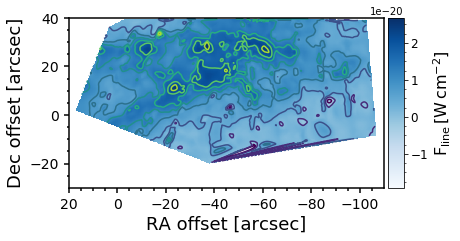

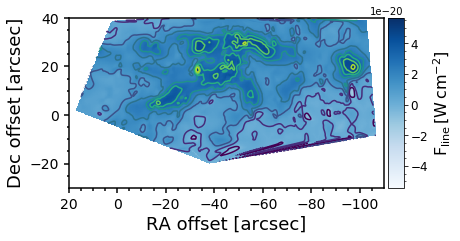

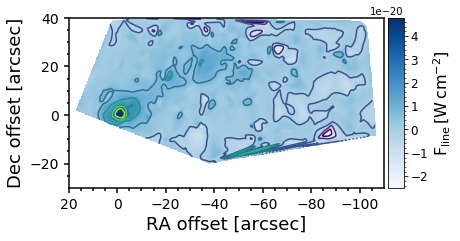

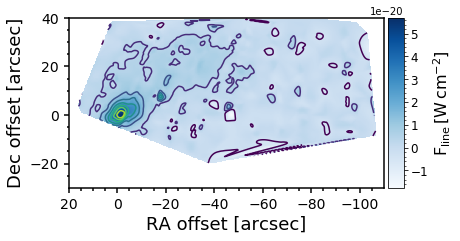

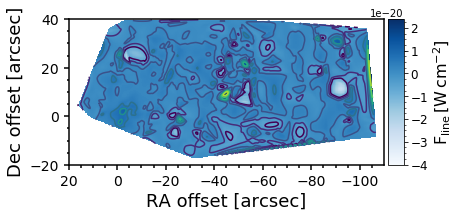

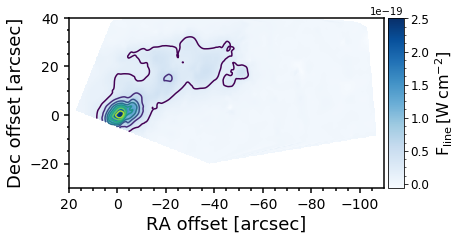

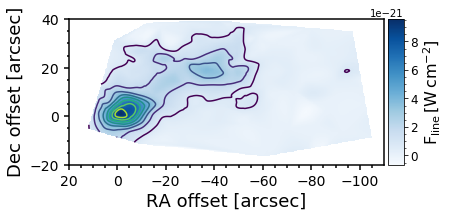

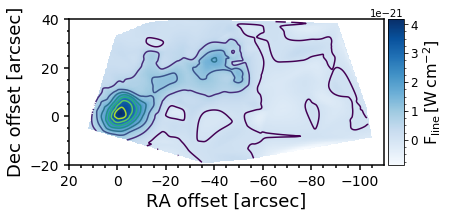

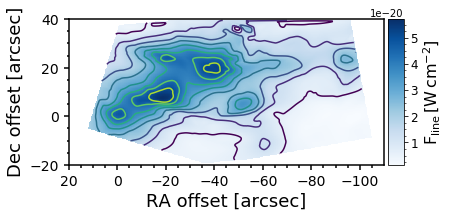

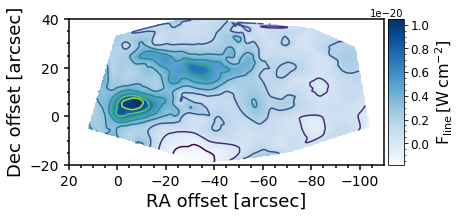

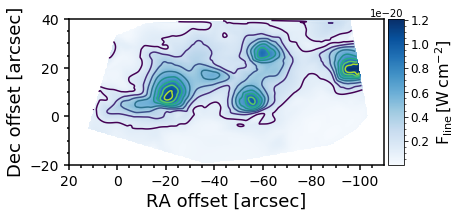

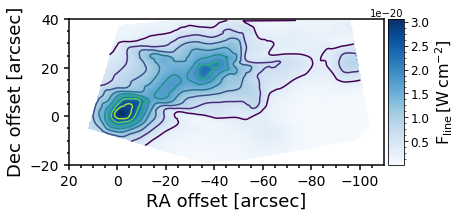

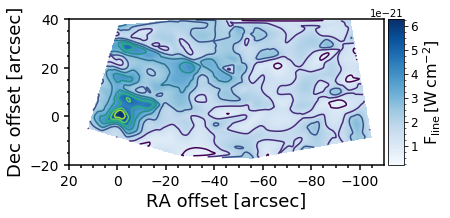

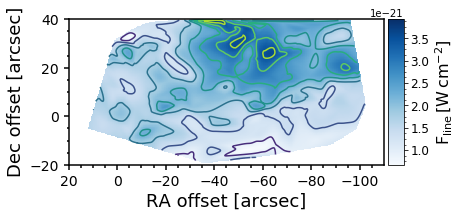

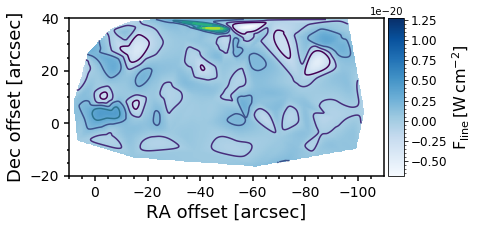

In [61]:
import os
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
feii_peak = SkyCoord('22:56:09 62:01:43', unit=(u.hourangle, u.degree))

if 'grad13yy' in os.path.expanduser('~'):
    indir = '/Users/yaolun/test/ggd37_fitting/'
else:
    indir = '/Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/'

# set the boundary limit to prevent erratic results at edges of grid
limits = {'Dec':[-np.inf, 62.039722222]}
    
# get line list from the fitting table
modules = ['SH', 'LH']
for m in modules:
    linelist = list(set(ascii.read(indir+m+'/ggd37_irs_'+m+'_lines.txt')['Line']))
#     print(linelist)

    for line in linelist:
        print('processing ', line)
        coord_rebin, z_list = CDF_contour(line, 'GGD37',
                                          indir+m+'/ggd37_irs_'+m+'_lines.txt',
                                          coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], cont=False, limits=limits,
                                          output=indir+m+'/'+line+'.fits', nofits=True, sigma_floor=3)

### SL

In [ ]:
# SL
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 6448
foo = open(indir+'SL/ggd37_irs_SL_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'SL/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

### plot contours for SL module

In [ ]:
# get line list from the fitting table
modules = ['SL']
indir = '/Users/yaolun/test/ggd37_fitting/'
for m in modules:
#     print(indir+m+'/ggd37_irs_'+m+'_lines.txt')
    linelist = list(set(ascii.read(indir+m+'/ggd37_irs_'+m+'_lines.txt')['Line']))
    print(linelist)

    for line in linelist:
        print('processing ', line)
        if line != 'NeII12':
            continue
        coord_rebin, z_list = CDF_contour(line, 'GGD37',
                                          indir+m+'/ggd37_irs_'+m+'_lines.txt',
                                          pix_cen=None, cont=False,
                                          output=indir+m+'/'+line+'.fits', nofits=True, # indir+m+'/'+line+'.fits'
                                          ggd37=True, offset=True)

## [FeII] lines comparison

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/astropy/table/column.py:929: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, oper)(other)
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in greater_equal


Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/feii35_contour.pdf
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/feii26_contour.pdf
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/feii24_contour.pdf
Figure saved at  /Users/yaolun/GoogleDrive/research/GGD37/feii18_contour.pdf


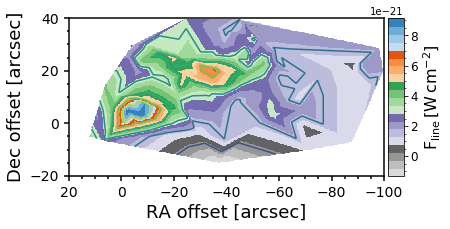

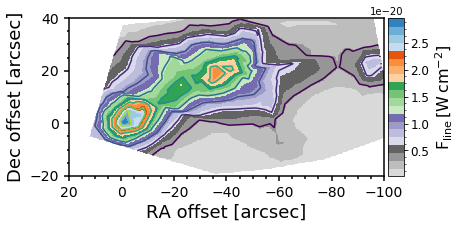

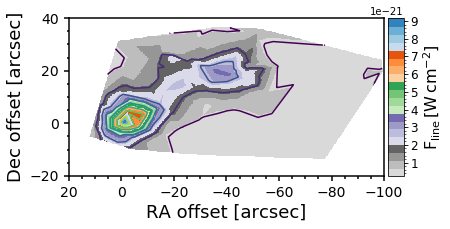

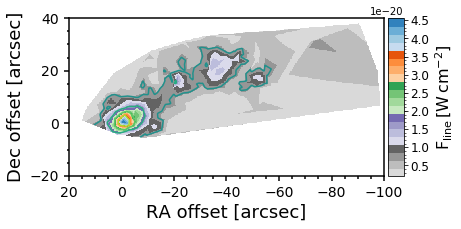

In [218]:
import os
from astropy.coordinates import SkyCoord
import astropy.units as u
feii_peak = SkyCoord('22:56:09 62:01:43', unit=(u.hourangle, u.degree))

if 'grad13yy' in os.path.expanduser('~'):
    indir = '/Users/yaolun/test/ggd37_fitting/'
else:
    indir = '/Users/yaolun/GoogleDrive/research/GGD37/ggd37_fitting/'
    
# set the boundary limit to prevent erratic results at edges of grid
limits = {'Dec':[-np.inf, 62.039722222]}
offset_sizes = [[-100, 20], [-20, 40]]

feii35 = CDF_contour('FeII35', 'GGD37', indir+'LH/ggd37_irs_LH_lines.txt',
                     coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
                     cont=False, offset=True, sigma_floor=5, cmap='tab20c_r', no_coords_output=True, offset_sizes=offset_sizes,
                     output='/Users/yaolun/GoogleDrive/research/GGD37/feii35')

feii26 = CDF_contour('FeII26', 'GGD37', indir+'LH/ggd37_irs_LH_lines.txt',
                     coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
                     cont=False, nofits=True, sigma_floor=5, cmap='tab20c_r', no_coords_output=True, offset_sizes=offset_sizes,
                     output='/Users/yaolun/GoogleDrive/research/GGD37/feii26')

feii24 = CDF_contour('FeII24', 'GGD37', indir+'LH/ggd37_irs_LH_lines.txt',
                     coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
                     cont=False, nofits=True, sigma_floor=5, cmap='tab20c_r', no_coords_output=True, offset_sizes=offset_sizes,
                     output='/Users/yaolun/GoogleDrive/research/GGD37/feii24')

# feii26_lowsnr = CDF_contour('FeII26', 'GGD37', indir+'LH/ggd37_irs_LH_lines.txt',
#                      coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
#                      cont=False, nofits=True, sigma_floor=0, cmap='tab20c_r', no_coords_output=True,
#                             output='/Users/yaolun/GoogleDrive/research/GGD37/feii26_lowsnr')
# feii24_lowsnr = CDF_contour('FeII24', 'GGD37', indir+'LH/ggd37_irs_LH_lines.txt',
#                      coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
#                      cont=False, nofits=True, sigma_floor=0, cmap='tab20c_r', no_coords_output=True,
#                             output='/Users/yaolun/GoogleDrive/research/GGD37/feii24_lowsnr')
feii18 = CDF_contour('FeII18', 'GGD37', indir+'SH/ggd37_irs_SH_lines.txt',
                     coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
                     cont=False, offset=True, sigma_floor=5, cmap='tab20c_r', no_coords_output=True, offset_sizes=offset_sizes,
                     output='/Users/yaolun/GoogleDrive/research/GGD37/feii18')

# neii12 = CDF_contour('NeII12', 'GGD37', indir+'SH/ggd37_irs_SH_lines.txt',
#                      coord_ref=[feii_peak.ra.degree, feii_peak.dec.degree], limits=limits,
#                      cont=False, nofits=False, offset=True, sigma_floor=3)


/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal


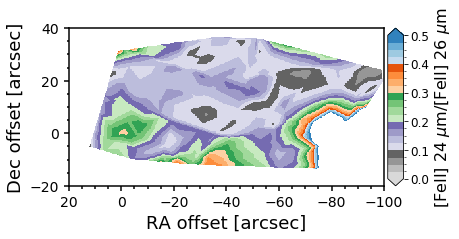

In [214]:
ratio_map([feii24[1][0], feii26[1][0]], [feii26[0][0], feii26[0][1]],
          labels=['[FeII] 24 $\mu$m', '[FeII] 26 $\mu$m'], vmax=0.5, vmin=0,
          outfile='/Users/yaolun/GoogleDrive/research/GGD37/feii24to26.pdf')

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal


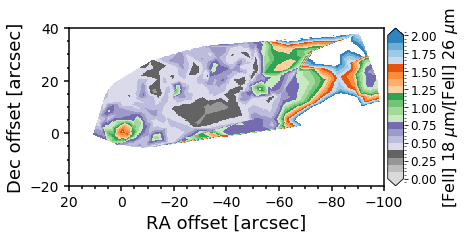

In [217]:
ratio_map([feii18[1][0], feii26[1][0]], [feii26[0][0], feii26[0][1]],
          labels=['[FeII] 18 $\mu$m', '[FeII] 26 $\mu$m'], vmax=2, vmin=0,
          outfile='/Users/yaolun/GoogleDrive/research/GGD37/feii18to26.pdf')

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal


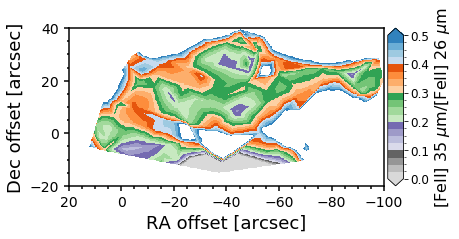

In [219]:
ratio_map([feii35[1][0], feii26[1][0]], [feii26[0][0], feii26[0][1]],
          labels=['[FeII] 35 $\mu$m', '[FeII] 26 $\mu$m'], vmax=0.5, vmin=0,
          outfile='/Users/yaolun/GoogleDrive/research/GGD37/feii35to26.pdf')

/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/yaolun/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal


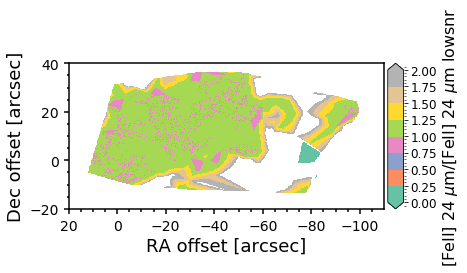

In [205]:
ratio_map([feii24[1][0], feii24_lowsnr[1][0]], [feii24[0][0], feii24[0][1]],
          labels=['[FeII] 24 $\mu$m', '[FeII] 24 $\mu$m lowsnr'], vmax=2, vmin=0, cmap='Set2',
          outfile='/Users/yaolun/GoogleDrive/research/GGD37/feii24tofeii24_lowsnr.pdf')

TODO:
    * better reference coodinates, probably where [FeII] peaks at. --done
    * trim the image --done, but need to double check with Joel, and apply to all SH & LH lines
    * use SNR cut --should work but not significant.  Adding the 'Validity' check actually matters a lot.
    * figure out the right bottom region.  Make a robust cut for it without changing the scale.
    * Significance of the secondary peak